# Image sementation with pytorch and Mask R-CNN
Dataset: penfundan https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip

In [7]:
import os
import torch
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import torchvision
from torchvision.transforms import functional as F
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2

## Dataset class

In [3]:
class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = sorted(os.listdir(os.path.join(root, "PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "PedMasks")))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)
        mask = np.array(mask)
        
        obj_ids = np.unique(mask)[1:]
        masks = mask == obj_ids[:, None, None]
        
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        # Преобразуем PIL.Image в тензор здесь
        img = F.to_tensor(img)
        
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks
        }
        
        if self.transforms:
            img, target = self.transforms(img, target)
        
        return img, target

    def __len__(self):
        return len(self.imgs)

## Download pretrained model

In [4]:
def get_model(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights=True)
    
    # bbox classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, 256, num_classes
    )
    
    return model

## Model training

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 2
batch_size = 1
num_epochs = 5

dataset = PennFudanDataset("PennFudanPed")
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

model = get_model(num_classes).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)


for epoch in range(num_epochs):
    model.train()
    for images, targets in data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses.item():.4f}")

c:\python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 0.3830
Epoch 2/5, Loss: 0.2720
Epoch 3/5, Loss: 0.1677
Epoch 4/5, Loss: 0.1443
Epoch 5/5, Loss: 0.1030


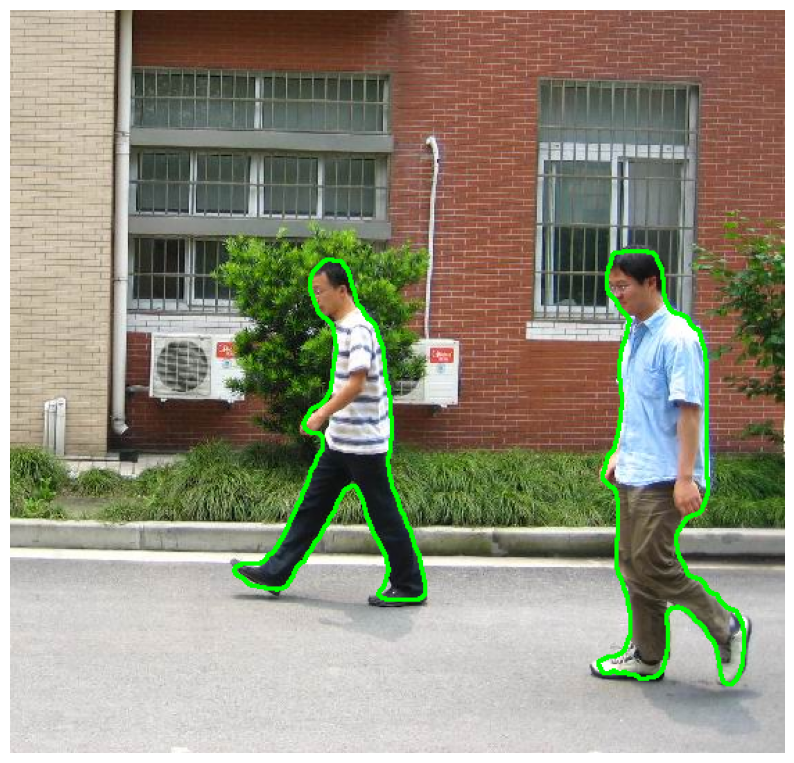

In [9]:
def plot_prediction(img_tensor, pred):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  
    
    for mask in pred["masks"]:
        mask = mask.squeeze().cpu().numpy()
        mask = (mask > 0.5).astype(np.uint8)
        
        contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        
        cv2.drawContours(img, contours, -1, (0, 255, 0), 2)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

model.eval()
img, _ = dataset[0]
with torch.no_grad():
    prediction = model([img.to(device)])[0]

plot_prediction(img, prediction)

# Keras

In [1]:
import os
import cv2
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2

In [2]:
dataset_path = 'PennFudanPed'

def load_dataset(dataset_path, target_size=(256, 256)):
    images = []
    masks = []
    
    img_dir = os.path.join(dataset_path, "PNGImages")
    mask_dir = os.path.join(dataset_path, "PedMasks")
    
    for img_name in os.listdir(img_dir):
        img_path = os.path.join(img_dir, img_name)
        mask_name = img_name.replace(".png", "_mask.png")
        mask_path = os.path.join(mask_dir, mask_name)
        
        if not os.path.exists(mask_path):
            continue
            
        img = Image.open(img_path).convert("RGB")
        img = img.resize(target_size)
        img = np.array(img)
        
        mask = Image.open(mask_path)
        mask = mask.resize(target_size, Image.NEAREST)  
        mask = np.array(mask)
        

        mask = (mask > 0).astype(np.float32)
        
        images.append(img)
        masks.append(mask[..., np.newaxis])  
        
    images = np.array(images)
    masks = np.array(masks)
    
    return images, masks

images, masks = load_dataset(dataset_path, target_size=(256, 256))

In [ ]:
def unet_model(input_shape=(256, 256, 3), num_classes=1):
    base_model = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    
    base_model.trainable = False
    
    skip_connection_names = [
        'input_1',                  # (256,256,3)
        'conv1_conv',               # (128,128,64)
        'conv2_block3_1_relu',      # (64,64,256)
        'conv3_block4_1_relu',      # (32,32,512)
        'conv4_block6_1_relu',      # (16,16,1024)
    ]
    
    s1, s2, s3, s4, bridge = [base_model.get_layer(name).output for name in skip_connection_names]
    
    def decoder_block(input_tensor, skip_tensor, filters):
        x = layers.Conv2DTranspose(filters, (3, 3), strides=2, padding='same')(input_tensor)
        
        if x.shape[1] != skip_tensor.shape[1] or x.shape[2] != skip_tensor.shape[2]:
            x = layers.UpSampling2D(size=(skip_tensor.shape[1]//x.shape[1], 
                                        skip_tensor.shape[2]//x.shape[2]))(x)
        
        if x.shape[1:] == skip_tensor.shape[1:]:
            x = layers.Concatenate()([x, skip_tensor])
        
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        return x
    
    d1 = decoder_block(bridge, s4, 512)  # (16,16,1024) -> (32,32,512)
    d2 = decoder_block(d1, s3, 256)      # (32,32,512) -> (64,64,256)
    d3 = decoder_block(d2, s2, 128)      # (64,64,256) -> (128,128,128)
    d4 = decoder_block(d3, s1, 64)       # (128,128,128) -> (256,256,64)
    
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)
    
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

model = unet_model(input_shape=(256, 256, 3))
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                                              

Loading dataset...

Sample visualization:


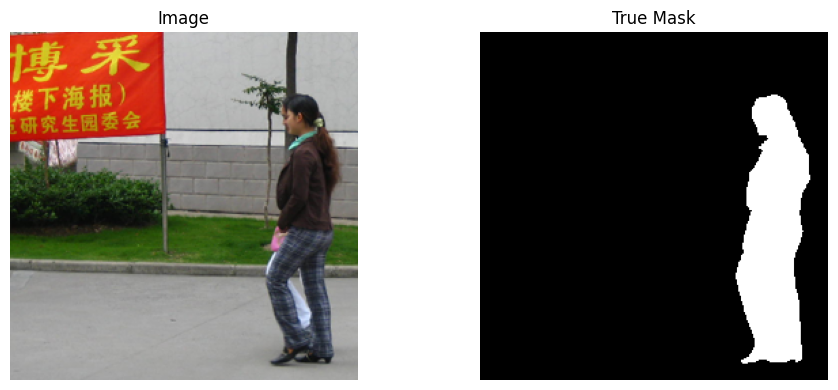


Building model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 130, 130, 64)         0         ['conv1_conv[0][0]']          
                                                                           

c:\python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


136/136 [==============================] - 68s 480ms/step - loss: 0.3897 - accuracy: 0.8814 - mean_io_u: 0.4235 - val_loss: 1.0576 - val_accuracy: 0.7365 - val_mean_io_u: 0.5833
Epoch 2/5
136/136 [==============================] - 72s 529ms/step - loss: 0.2401 - accuracy: 0.9120 - mean_io_u: 0.4143 - val_loss: 0.2079 - val_accuracy: 0.9158 - val_mean_io_u: 0.4217
Epoch 3/5
136/136 [==============================] - 73s 540ms/step - loss: 0.1951 - accuracy: 0.9219 - mean_io_u: 0.4223 - val_loss: 0.2990 - val_accuracy: 0.8826 - val_mean_io_u: 0.4201
Epoch 4/5
136/136 [==============================] - 115s 850ms/step - loss: 0.1751 - accuracy: 0.9291 - mean_io_u: 0.4123 - val_loss: 0.2243 - val_accuracy: 0.8991 - val_mean_io_u: 0.4190
Epoch 5/5
136/136 [==============================] - 67s 490ms/step - loss: 0.1569 - accuracy: 0.9370 - mean_io_u: 0.4123 - val_loss: 0.1983 - val_accuracy: 0.9149 - val_mean_io_u: 0.4190

Evaluating model...
1/1 [==============================] - 1s 633ms/

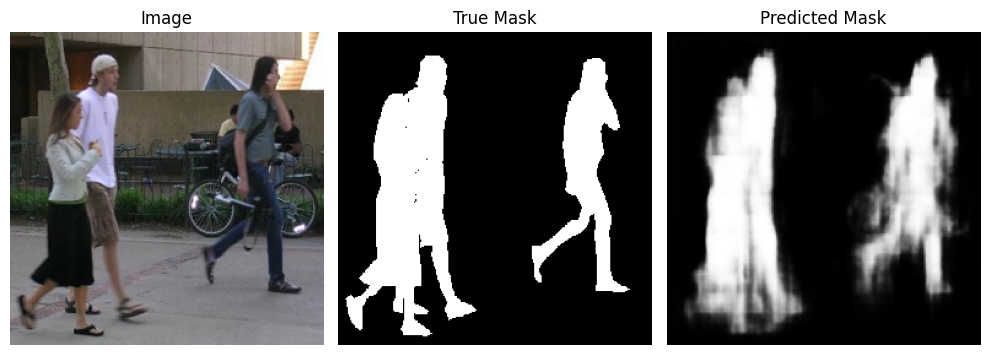

In [1]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

def load_dataset(dataset_path, target_size=(256, 256)):
    images = []
    masks = []
    
    img_dir = os.path.join(dataset_path, "PNGImages")
    mask_dir = os.path.join(dataset_path, "PedMasks")
    
    for img_name in sorted(os.listdir(img_dir)):
        img_path = os.path.join(img_dir, img_name)
        mask_name = img_name.replace(".png", "_mask.png")
        mask_path = os.path.join(mask_dir, mask_name)
        
        if not os.path.exists(mask_path):
            continue
            
        img = Image.open(img_path).convert("RGB")
        img = img.resize(target_size)
        img = np.array(img) / 255.0
        
        mask = Image.open(mask_path)
        mask = mask.resize(target_size, Image.NEAREST)
        mask = (np.array(mask) > 0).astype(np.float32)
        
        images.append(img)
        masks.append(mask[..., np.newaxis])
    
    return np.array(images), np.array(masks)

def build_unet(input_shape=(256, 256, 3)):
    base_model = ResNet50V2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False
    
    #  skip-connections
    s1 = base_model.get_layer("input_1").output           # (256,256,3)
    s2 = base_model.get_layer("conv1_conv").output       # (128,128,64)
    s3 = base_model.get_layer("conv2_block3_out").output # (64,64,256)
    s4 = base_model.get_layer("conv3_block4_out").output # (32,32,512)
    bridge = base_model.get_layer("conv4_block6_out").output # (16,16,1024)
    

    def decoder_block(input_tensor, skip_tensor, filters):
        x = layers.Conv2DTranspose(filters, (3, 3), strides=2, padding='same')(input_tensor)
        

        if x.shape[1] != skip_tensor.shape[1]:
            x = layers.UpSampling2D(size=(2, 2))(x)
        
        x = layers.Concatenate()([x, skip_tensor])
        x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        return x
    
    d1 = decoder_block(bridge, s4, 512)  # (16,16,1024) -> (32,32,512)
    d2 = decoder_block(d1, s3, 256)     # (32,32,512) -> (64,64,256)
    d3 = decoder_block(d2, s2, 128)     # (64,64,256) -> (128,128,128)
    

    u4 = layers.UpSampling2D((2, 2))(d3)  # (128,128,128) -> (256,256,128)
    u4 = layers.Concatenate()([u4, s1])  
    u4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u4)
    u4 = layers.BatchNormalization()(u4)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u4)
    
    return models.Model(inputs=base_model.input, outputs=outputs)

def plot_sample(image, mask, pred_mask=None):
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 3 if pred_mask is not None else 2, 1)
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')
    
    plt.subplot(1, 3 if pred_mask is not None else 2, 2)
    plt.imshow(mask.squeeze(), cmap='gray')
    plt.title("True Mask")
    plt.axis('off')
    
    if pred_mask is not None:
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def main():
    DATA_PATH = "PennFudanPed"
    BATCH_SIZE = 1
    EPOCHS = 5
    INPUT_SHAPE = (256, 256, 3)
    
    print("Loading dataset...")
    images, masks = load_dataset(DATA_PATH, target_size=INPUT_SHAPE[:2])
    X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)
    
  
    print("\nSample visualization:")
    plot_sample(X_train[0], y_train[0])
    
    print("\nBuilding model...")
    model = build_unet(INPUT_SHAPE)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)]
    )
    model.summary()
    
    print("\nTraining model...")
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ModelCheckpoint("best_model.h5", save_best_only=True)
    ]
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=callbacks
    )
    
    print("\nEvaluating model...")
    sample_idx = 0
    pred_mask = model.predict(X_val[sample_idx][np.newaxis, ...])[0]
    plot_sample(X_val[sample_idx], y_val[sample_idx], pred_mask)

main()